In [1]:
import numpy as np
import cupy as cp
from holotomocupy.utils import *
from holotomocupy.holo import G
from holotomocupy.shift import S
from holotomocupy.tomo import R
from holotomocupy.chunking import gpu_batch
%matplotlib inline

np.random.seed(1) # fix randomness

astropy module not found
olefile module not found


In [2]:
# !jupyter nbconvert --to script modeling_codes.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [26]:
n = 256  # object size in each dimension

ntheta = 180  # number of angles (rotations)
noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True



flg = f'{n}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'



### Form the refractive index u = delta+i beta for a sample

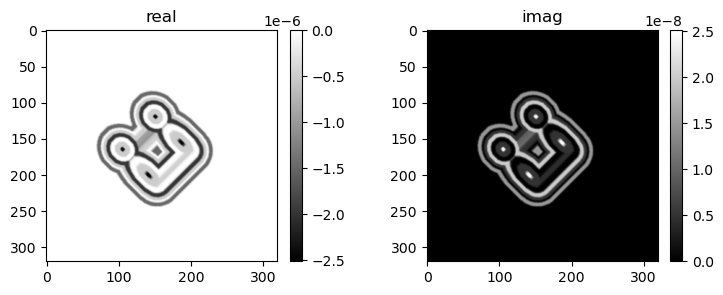

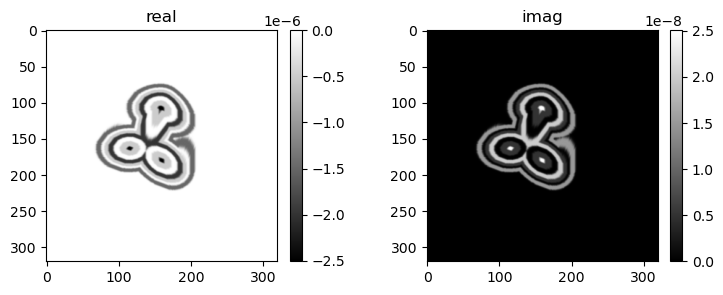

In [27]:
from scipy import ndimage

cube_all = np.zeros([n, n, n], dtype='float32')
rr = (np.ones(8)*n*0.25).astype(np.int32)
amps = [3, -3, 1, 3, -4, 1, 4]  # , -2, -4, 5 ]
dil = np.array([33, 28, 25, 21, 16, 10, 3])/256*n  # , 6, 3,1]
for kk in range(len(amps)):
    cube = np.zeros([n, n, n], dtype='bool')
    r = rr[kk]
    p1 = n//2-r//2
    p2 = n//2+r//2
    for k in range(3):
        cube = cube.swapaxes(0, k)
        cube[p1:p2, p1, p1] = True
        cube[p1:p2, p1, p2] = True
        cube[p1:p2, p2, p1] = True
        cube[p1:p2, p2, p2] = True
        # cube[p1:p2,p2,p2] = True

    [x, y, z] = np.meshgrid(np.arange(-n//2, n//2),
                            np.arange(-n//2, n//2), np.arange(-n//2, n//2))
    circ = (x**2+y**2+z**2) < dil[kk]**2
    # circ = (x**2<dil[kk]**2)*(y**2<dil[kk]**2)*(z**2<dil[kk]**2)

    fcirc = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(circ)))
    fcube = np.fft.fftshift(np.fft.fftn(
        np.fft.fftshift(cube.astype('float32'))))
    cube = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fcube*fcirc))).real
    cube = cube > 1
    cube_all += amps[kk]*cube

# cube_all = ndimage.rotate(cube_all,52,axes=(1,2),reshape=False,order=1)
cube_all = ndimage.rotate(cube_all, 28, axes=(0, 1), reshape=False, order=3)
cube_all = ndimage.rotate(cube_all, 45, axes=(0, 2), reshape=False, order=3)
cube_all[cube_all < 0] = 0


u0 = cube_all  # (-1*cube_all*1e-6+1j*cube_all*1e-8)/3

u0 = np.roll(u0, -15*n//256, axis=2)
u0 = np.roll(u0, -10*n//256, axis=1)
v = np.arange(-n//2, n//2)/n
[vx, vy, vz] = np.meshgrid(v, v, v)
v = np.exp(-10*(vx**2+vy**2+vz**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u0)))
u0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real
u0[u0 < 0] = 0
u0 = u0*(-1*1e-6+1j*1e-8)/2
u = u0.astype('complex64')  

!mkdir -p data
np.save(f'{path}/u.npy', u0)

# if exist then load and comment the above
u = np.load(f'{path}/u.npy').astype('complex64')
dxchange.write_tiff(-u.real,'/data/tmp/cube',overwrite=True)
u = np.pad(u,((pad,pad),(pad,pad),(pad,pad)))
mshow_complex(u[:, n//2],show)
mshow_complex(u[n//2],show)

### Compute tomographic projection data $\mathcal{R}u$:

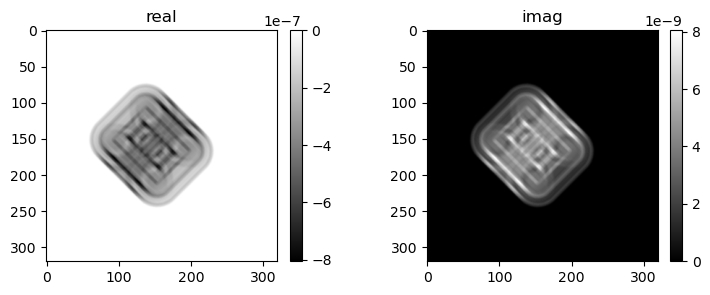

In [28]:
center_pad = u.shape[-1]//2
Ru = R(u, theta, center_pad)
Ru = Ru.swapaxes(0, 1)
mshow_complex(Ru[0],show)

### Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

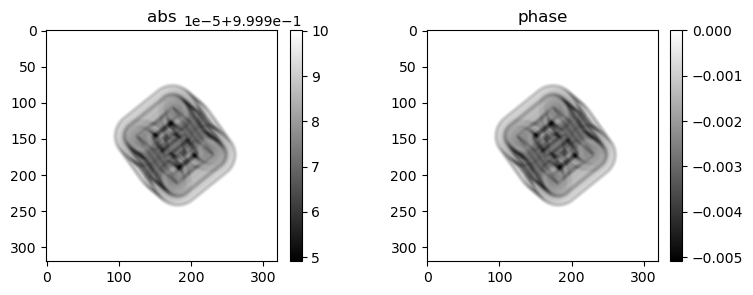

In [29]:
def exptomo(psi):
    """Exp representation of projections"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength)

psi = exptomo(Ru)
mshow_polar(psi[ntheta//4*3],show)

## Read the probe. 

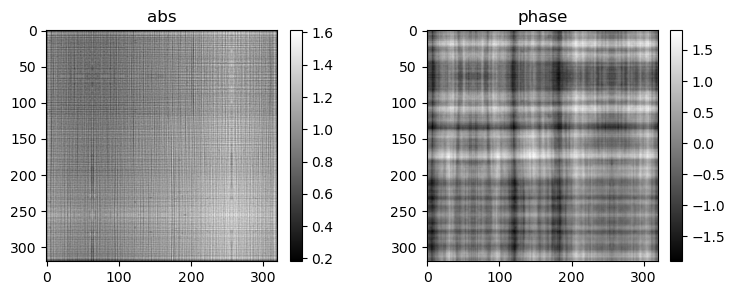

In [15]:
flg = f'{2048}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'
prb = np.load(f'{path}/data/prb_{flg}.npy')
for k in range(np.int32(np.log2(2048//n))):
    prb = 0.5*(prb[:,::2]+prb[:,1::2])
    prb = 0.5*(prb[:,:,::2]+prb[:,:,1::2])
mshow_polar(prb[0],show)

### Generate a coded aperture, make it twice bigger than the sample to allow motion

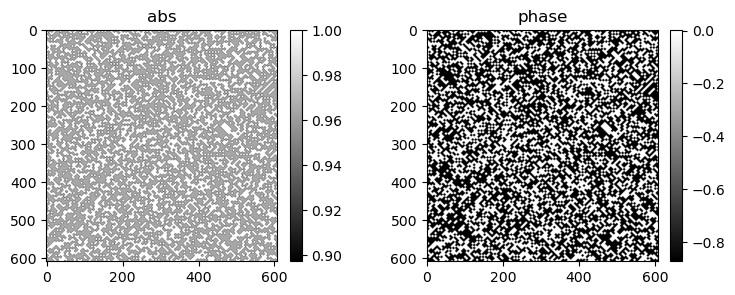

In [19]:
code = np.load(f'{path}/data/code_{flg}.npy')
for k in range(np.int32(np.log2(2048//n))):
    code = 0.5*(code[:,::2]+code[:,1::2])
    code = 0.5*(code[:,:,::2]+code[:,:,1::2])
mshow_polar(code[0],show)

### Shifts of the code

In [20]:
# shifts of codes
shifts_code = np.round((np.random.random([ntheta, npos, 2]).astype('float32')-0.5)*ne/4)

#### Forward operator

In [21]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        
        # shift and crop thecode 
        coder = S(coder, shifts_code[:, i])
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        coder *= prbr
        
        # propagate the code to the probe plane
        coder = G(coder, wavelength, voxelsize, distances2[i])
        
        # multiply the ill code and object
        psir *= (coder)                
        # propagate all to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)

@gpu_batch
def _fwd_holo0(prb):    
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for j in range(npos):
        # propagate illumination 
        data[:,j] = G(prb, wavelength, voxelsize, distances[0]+distances2[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb)

# Apply the forward transform
psi = cp.array(psi)
prb = cp.array(prb)
code = cp.array(code)
shifts_code = cp.array(shifts_code)
fpsi = fwd_holo(psi, prb)
fref = fwd_holo0(prb)

### Take squared absolute value to simulate data on the detector and a reference image

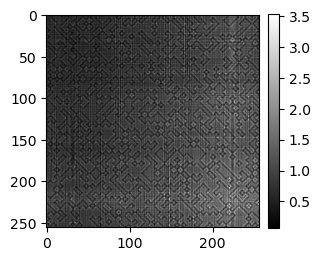

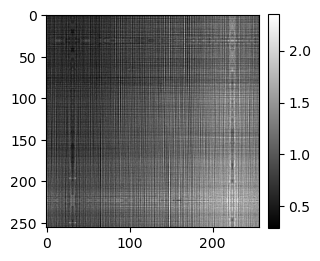

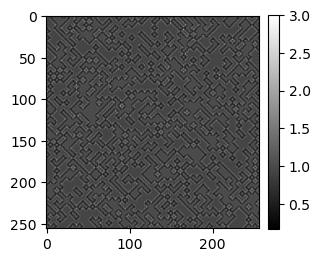

In [22]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2
# show a data example
# mshow(data[0,0],show,vmax=1.8,vmin=0.5)
# mshow(ref[0,0],show)
mshow(data[0,0],show)
mshow(ref[0,0],show)
if noise>0:
    data_noise = cp.random.poisson(data*noise).astype('float32')/noise
    ref_noise = cp.random.poisson(ref*noise).astype('float32')/noise
    mshow(data[0,0]-data_noise[0,0])
    data=data_noise
    ref=ref_noise

mshow(data[0,0]/ref[0,0],show,vmax=3)

### Save data and the code

In [12]:
for k in range(npos):
    write_tiff(data[:,k],f'/data2/vnikitin/coded_apertures_new3/data/data_{k}_{flg}')
for k in range(npos):
    write_tiff(ref[:,k],f'/data2/vnikitin/coded_apertures_new3/data/ref_{k}_{flg}')
np.save(f'/data2/vnikitin/coded_apertures_new3/data/code_{flg}',code)
np.save(f'/data2/vnikitin/coded_apertures_new3/data/shifts_code_{flg}', shifts_code)
np.save(f'/data2/vnikitin/coded_apertures_new3/data/prb_{flg}', prb)


: 